In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/customer-churn-prediction-2020/sampleSubmission.csv
/kaggle/input/customer-churn-prediction-2020/test.csv
/kaggle/input/customer-churn-prediction-2020/train.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score,classification_report,roc_auc_score,roc_curve
from lightgbm import LGBMClassifier,plot_importance
from sklearn.preprocessing import StandardScaler

In [3]:
train = pd.read_csv('/kaggle/input/customer-churn-prediction-2020/train.csv')
test = pd.read_csv('/kaggle/input/customer-churn-prediction-2020/test.csv')
train.shape,test.shape

((4250, 20), (750, 20))

In [4]:
train.head(3)

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
1,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
2,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no


In [5]:
train.state = pd.Categorical(train.state).codes
train.area_code = pd.Categorical(train.area_code).codes
train.international_plan = pd.Categorical(train.international_plan).codes
train.voice_mail_plan = pd.Categorical(train.voice_mail_plan).codes
train.churn = pd.Categorical(train.churn).codes
test.state = pd.Categorical(test.state).codes
test.area_code = pd.Categorical(test.area_code).codes
test.international_plan = pd.Categorical(test.international_plan).codes
test.voice_mail_plan = pd.Categorical(test.voice_mail_plan).codes

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4250 entries, 0 to 4249
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   state                          4250 non-null   int8   
 1   account_length                 4250 non-null   int64  
 2   area_code                      4250 non-null   int8   
 3   international_plan             4250 non-null   int8   
 4   voice_mail_plan                4250 non-null   int8   
 5   number_vmail_messages          4250 non-null   int64  
 6   total_day_minutes              4250 non-null   float64
 7   total_day_calls                4250 non-null   int64  
 8   total_day_charge               4250 non-null   float64
 9   total_eve_minutes              4250 non-null   float64
 10  total_eve_calls                4250 non-null   int64  
 11  total_eve_charge               4250 non-null   float64
 12  total_night_minutes            4250 non-null   f

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3b183b4d10>,
      dtype=object)

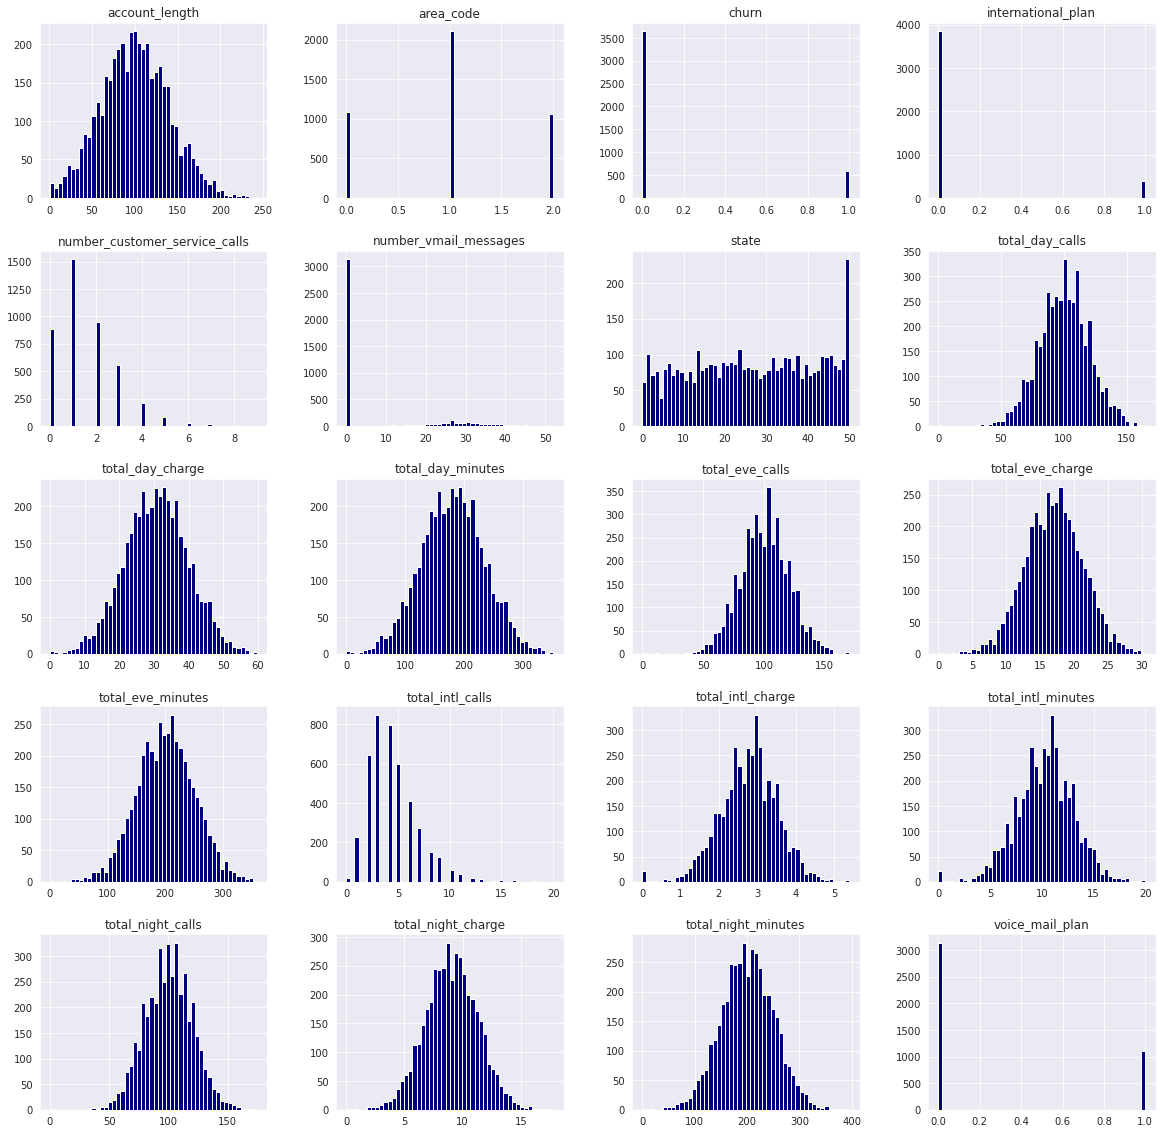

In [7]:
sns.set_style('dark')
train.hist(bins=50,figsize=(20,20),color='navy')

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


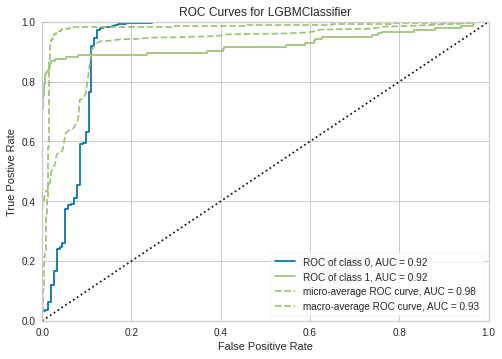

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


ROCAUC(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f3b1006a290>,
       classes=[0, 1], model=None)

In [8]:
X = train.drop('churn',axis=1)
y  = train.churn
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=1)
from yellowbrick.classifier import roc_auc
roc_auc(LGBMClassifier(),X_train,y_train,X_test = X_test, y_test = y_test,
       classes=[0,1])

In [9]:
X_train = train.drop('churn',axis=1)
y_train = train.churn
X_test = test.drop('id',axis=1)

In [10]:
scaler = StandardScaler()
X_train.number_vmail_messages = scaler.fit_transform(X_train.number_vmail_messages.values.reshape(-1,1))
X_test.number_vmail_messages = scaler.fit_transform(X_test.number_vmail_messages.values.reshape(-1,1))

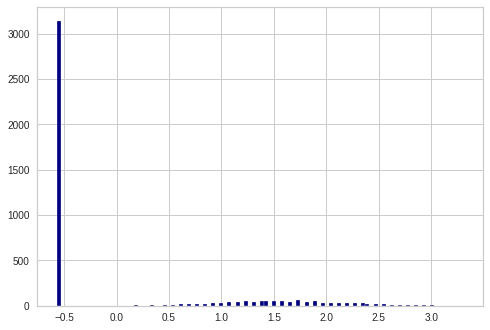

In [11]:
X_train.number_vmail_messages.hist(bins=100,color='navy')

In [12]:
light = LGBMClassifier(n_estimators=200,learning_rate=0.11,
                      min_child_samples=30,num_leaves=60)
light.fit(X_train,y_train)

LGBMClassifier(learning_rate=0.11, min_child_samples=30, n_estimators=200,
               num_leaves=60)

In [13]:
pred = light.predict(X_test)

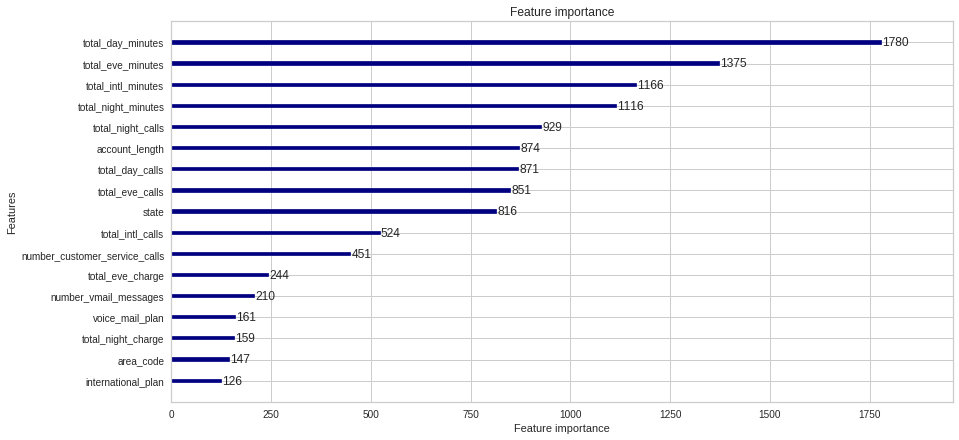

In [14]:
plt.rcParams["figure.figsize"] = (14, 7)
plot_importance(light,color='navy',)